# HM2: Numerical Optimization for Logistic Regression.

### Name: Amir Morcos


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Logistic/paper/logistic.pdf)

2. Read, complete, and run my code.

3. **Implement mini-batch SGD** and evaluate the performance.

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
    * Missing **the output after execution** will not be graded.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo.  (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/HM2/HM2.html


## Grading criteria:

1. When computing the ```gradient``` and ```objective function value``` using a batch of samples, use **matrix-vector multiplication** rather than a FOR LOOP of **vector-vector multiplications**.

2. Plot ```objective function value``` against ```epochs```. In the plot, compare GD, SGD, and MB-SGD (with $b=8$ and $b=64$). The plot must look reasonable.

# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [1]:
from sklearn import datasets
import numpy
import matplotlib.pyplot as plt
%matplotlib inline


x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [2]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [3]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[-0.05552093 -0.11915207 -0.12174774 -0.06419547  0.00873894 -0.12002747
  -0.08711292  0.03082183]]
test std = 
[[0.9299173  1.13226076 0.80840115 0.97029108 1.1454821  1.01922977
  0.92209507 1.07166721]]


## 1.4. Add a dimension of all ones

In [4]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


# 2. Logistic regression model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

In [5]:
# Calculate the objective function value
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     objective function value (scalar)
def objective(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(-yxw) # n-by-1 matrix
    vec2 = numpy.log(1 + vec1) # n-by-1 matrix
    loss = numpy.mean(vec2) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    return loss + reg
    

In [6]:
# initialize w
d = x_train.shape[1]
w = numpy.zeros((d, 1))

# evaluate the objective function value at w
lam = 1E-6
objval0 = objective(w, x_train, y_train, lam)
print('Initial objective function value = ' + str(objval0))

Initial objective function value = 0.6931471805599453


# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ is $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [7]:
# Calculate the gradient
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     g: g: d-by-1 matrix, full gradient
def gradient(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(yxw) # n-by-1 matrix
    vec2 = numpy.divide(yx, 1+vec1) # n-by-d matrix
    vec3 = -numpy.mean(vec2, axis=0).reshape(d, 1) # d-by-1 matrix
    g = vec3 + lam * w
    return g

In [8]:
# Gradient descent for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_iter: integer, the maximal iterations
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: d-by-1 matrix, the solution
#     objvals: a record of each iteration's objective value
def grad_descent(x, y, lam, stepsize, max_iter=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_iter) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_iter):
        objval = objective(w, x, y, lam)
        objvals[t] = objval
        print('Objective value at t=' + str(t) + ' is ' + str(objval))
        g = gradient(w, x, y, lam)
        w -= stepsize * g
    
    return w, objvals

Run gradient descent.

In [9]:
lam = 1E-6
stepsize = 1.0
w, objvals_gd = grad_descent(x_train, y_train, lam, stepsize)

Objective value at t=0 is 0.6931471805599453
Objective value at t=1 is 0.5899623840544399
Objective value at t=2 is 0.5484120217716956
Objective value at t=3 is 0.5262658587863709
Objective value at t=4 is 0.5125641809742634
Objective value at t=5 is 0.503359198128985
Objective value at t=6 is 0.496853073881939
Objective value at t=7 is 0.4920944056556387
Objective value at t=8 is 0.488526599502566
Objective value at t=9 is 0.485800584333963
Objective value at t=10 is 0.48368620915472815
Objective value at t=11 is 0.4820259480014747
Objective value at t=12 is 0.48070880553968176
Objective value at t=13 is 0.47965472501059164
Objective value at t=14 is 0.47880483793269996
Objective value at t=15 is 0.4781151424852264
Objective value at t=16 is 0.4775522827083435
Objective value at t=17 is 0.4770906606079848
Objective value at t=18 is 0.4767104186627837
Objective value at t=19 is 0.47639600467751214
Objective value at t=20 is 0.47613513447277034
Objective value at t=21 is 0.4759180313706

## 3.2. Stochastic gradient descent (SGD)

Define $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [10]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: d-by-1 matrix
#     xi: 1-by-d matrix
#     yi: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def stochastic_objective_gradient(w, xi, yi, lam):
    d = xi.shape[0]
    yx = yi * xi # 1-by-d matrix
    yxw = float(numpy.dot(yx, w)) # scalar
    
    # calculate objective function Q_i
    loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj = loss + reg
    
    # calculate stochastic gradient
    g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
    g = g_loss + lam * w # d-by-1 matrix
    
    return obj, g

In [11]:
# SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def sgd(x, y, lam, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        objval = 0 # accumulate the objective values
        for i in range(n):
            xi = x_rand[i, :] # 1-by-d matrix
            yi = float(y_rand[i, :]) # scalar
            obj, g = stochastic_objective_gradient(w, xi, yi, lam)
            objval += obj
            w -= stepsize * g
        
        stepsize *= 0.9 # decrease step size
        objval /= n
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals

Run SGD.

In [12]:
lam = 1E-6
stepsize = 0.1
w, objvals_sgd = sgd(x_train, y_train, lam, stepsize)

Objective value at epoch t=0 is 0.5231391515081497
Objective value at epoch t=1 is 0.5240806070594753
Objective value at epoch t=2 is 0.5153351282856871
Objective value at epoch t=3 is 0.5156457705541975
Objective value at epoch t=4 is 0.5137218385521376
Objective value at epoch t=5 is 0.5047677219495815
Objective value at epoch t=6 is 0.5057098143359106
Objective value at epoch t=7 is 0.5013639337785234
Objective value at epoch t=8 is 0.49644324920831684
Objective value at epoch t=9 is 0.5003460104772132
Objective value at epoch t=10 is 0.49398806564450054
Objective value at epoch t=11 is 0.49383753955856624
Objective value at epoch t=12 is 0.4893280089465722
Objective value at epoch t=13 is 0.49159622356639054
Objective value at epoch t=14 is 0.48518404212744165
Objective value at epoch t=15 is 0.4884248111279179
Objective value at epoch t=16 is 0.4850310871498233
Objective value at epoch t=17 is 0.4856637945940931
Objective value at epoch t=18 is 0.48253767573451223
Objective value 

# 4. Compare GD with SGD

Plot objective function values against epochs.

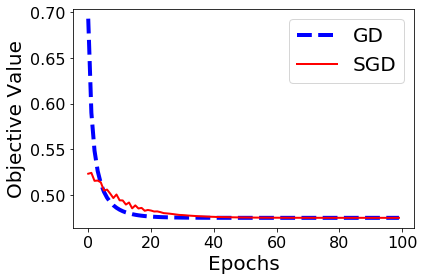

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1], ['GD', 'SGD'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)

# 5. Prediction

In [14]:
# Predict class label
# Inputs:
#     w: d-by-1 matrix
#     X: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f

In [15]:
# evaluate training error
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

Training classification error is 0.2265625


In [16]:
# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Test classification error is 0.203125


# 6. Mini-batch SGD (fill the code)



## 6.1. Compute the objective $Q_I$ and its gradient using a batch of samples

Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [17]:
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: d-by-1 matrix
#     xi: b-by-d matrix
#     yi: b-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def mb_stochastic_objective_gradient(w, xi, yi, lam, b):
    # Fill the function
    # Follow the implementation of stochastic_objective_gradient
    # Use matrix-vector multiplication; do not use FOR LOOP of vector-vector multiplications
    n, d = xi.shape
    yx = numpy.multiply(yi, xi) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    Obj_vec1 = numpy.exp(-yxw) # n-by-1 matrix
    Obj_vec2 = numpy.log(1 + Obj_vec1) # n-by-1 matrix
    loss = numpy.mean(Obj_vec2) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj =  loss + reg

    Gvec1 = numpy.exp(yxw) # n-by-1 matrix
    Gvec2 = numpy.divide(yx, 1+Gvec1) # n-by-d matrix
    Gvec3 = -numpy.mean(Gvec2, axis=0).reshape(d, 1) # d-by-1 matrix
    g = Gvec3 + lam * w
    return obj, g

## 6.2. Implement mini-batch SGD

Hints:
1. In every epoch, randomly permute the $n$ samples (just like SGD).
2. Each epoch has $\frac{n}{b}$ iterations. In every iteration, use $b$ samples, and compute the gradient and objective using the ``mb_stochastic_objective_gradient`` function. In the next iteration, use the next $b$ samples, and so on.


In [18]:
# Mini-Batch SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def mb_sgd(x, y, lam, b, stepsize, max_epoch=100, w=None):
    # Fill the function
    # Follow the implementation of sgd
    # Record one objective value per epoch (not per iteration!)
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        objval = 0 # accumulate the objective values
        for i in range(0,n,b):
            xi = x_rand[i:i+b, :] # b-by-d matrix
            yi = y_rand[i:i+b,:]
            obj, g = mb_stochastic_objective_gradient(w, xi, yi, lam,b)
            
            objval += obj
            w -= stepsize * g
        
        stepsize *= 0.9 # decrease step size
        objval /= (n/b)
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals

## 6.3. Run MB-SGD

In [19]:
def try6mbsdg (b,STs):

    lam = 1E-6 # do not change
    fig = plt.figure(figsize=(8, 8))
    
    _, objvals_mbsgdst1 = mb_sgd(x_train, y_train, lam, b, STs[0])
    _, objvals_mbsgdst2 = mb_sgd(x_train, y_train, lam, b, STs[1])
    _, objvals_mbsgdst3 = mb_sgd(x_train, y_train, lam, b, STs[2])
    _, objvals_mbsgdst4 = mb_sgd(x_train, y_train, lam, b, STs[3])
    _, objvals_mbsgdst5 = mb_sgd(x_train, y_train, lam, b, STs[4])
    _, objvals_mbsgdst6 = mb_sgd(x_train, y_train, lam, b, STs[5])
    
    epochs = range(len(objvals_mbsgdst1))
    
    line0, = plt.plot(epochs, objvals_mbsgdst1, '--b', LineWidth=1)
    line1, = plt.plot(epochs, objvals_mbsgdst2, '-g', LineWidth=1)
    line2, = plt.plot(epochs, objvals_mbsgdst3, '-r', LineWidth=1)
    line3, = plt.plot(epochs, objvals_mbsgdst4, '-c', LineWidth=1)
    line4, = plt.plot(epochs, objvals_mbsgdst5, '-m', LineWidth=1)
    line5, = plt.plot(epochs, objvals_mbsgdst6, '--k', LineWidth=1)
    plt.xlabel('Epochs', FontSize=10)
    plt.ylabel('Objective Value', FontSize=10)
    plt.xticks(FontSize=8)
    plt.yticks(FontSize=8)
    plt.legend([line0, line1,line2,line3,line4,line5], STs, fontsize=10)
    plt.tight_layout()
    plt.show()


    
    

Objective value at epoch t=0 is 0.6706679794078084
Objective value at epoch t=1 is 0.6342257966322179
Objective value at epoch t=2 is 0.6093159951760174
Objective value at epoch t=3 is 0.5916906122132319
Objective value at epoch t=4 is 0.5786339677789405
Objective value at epoch t=5 is 0.5686210147649112
Objective value at epoch t=6 is 0.560789193331573
Objective value at epoch t=7 is 0.5545397516858709
Objective value at epoch t=8 is 0.5494815332509699
Objective value at epoch t=9 is 0.5452823927373971
Objective value at epoch t=10 is 0.5418044208945095
Objective value at epoch t=11 is 0.5388659839678663
Objective value at epoch t=12 is 0.5363839583737668
Objective value at epoch t=13 is 0.5342776472441269
Objective value at epoch t=14 is 0.5324542788093193
Objective value at epoch t=15 is 0.5308695436225394
Objective value at epoch t=16 is 0.5294974050824954
Objective value at epoch t=17 is 0.5283092072801564
Objective value at epoch t=18 is 0.5272678018367045
Objective value at epoc

Objective value at epoch t=72 is 0.49114943844655123
Objective value at epoch t=73 is 0.4911479967297572
Objective value at epoch t=74 is 0.49114669556558993
Objective value at epoch t=75 is 0.4911455754443278
Objective value at epoch t=76 is 0.49114446981423343
Objective value at epoch t=77 is 0.49114353291927654
Objective value at epoch t=78 is 0.4911426955871689
Objective value at epoch t=79 is 0.49114194041071524
Objective value at epoch t=80 is 0.4911412396496311
Objective value at epoch t=81 is 0.4911406142631298
Objective value at epoch t=82 is 0.49114003729717143
Objective value at epoch t=83 is 0.49113955317353025
Objective value at epoch t=84 is 0.4911391061798692
Objective value at epoch t=85 is 0.49113870084237715
Objective value at epoch t=86 is 0.49113833951090174
Objective value at epoch t=87 is 0.4911380049320518
Objective value at epoch t=88 is 0.4911377057425043
Objective value at epoch t=89 is 0.49113742732484783
Objective value at epoch t=90 is 0.4911371915354
Objec

Objective value at epoch t=30 is 0.4752076393428604
Objective value at epoch t=31 is 0.47513664155239066
Objective value at epoch t=32 is 0.4750780820143972
Objective value at epoch t=33 is 0.47504862817640736
Objective value at epoch t=34 is 0.47502977502282906
Objective value at epoch t=35 is 0.4750182151771015
Objective value at epoch t=36 is 0.47496910075956544
Objective value at epoch t=37 is 0.4749581450211128
Objective value at epoch t=38 is 0.4749246994757481
Objective value at epoch t=39 is 0.4749026055897464
Objective value at epoch t=40 is 0.4749138183971418
Objective value at epoch t=41 is 0.47488181440413746
Objective value at epoch t=42 is 0.47488453149314863
Objective value at epoch t=43 is 0.47486586968291417
Objective value at epoch t=44 is 0.47485662937338835
Objective value at epoch t=45 is 0.4748519863144729
Objective value at epoch t=46 is 0.47483356820237
Objective value at epoch t=47 is 0.47482993378202937
Objective value at epoch t=48 is 0.4748143026565452
Objec

Objective value at epoch t=91 is 0.47476342069657845
Objective value at epoch t=92 is 0.47476340512570536
Objective value at epoch t=93 is 0.47476323605158405
Objective value at epoch t=94 is 0.4747631906184794
Objective value at epoch t=95 is 0.47476316405025776
Objective value at epoch t=96 is 0.4747629416900569
Objective value at epoch t=97 is 0.4747629233333222
Objective value at epoch t=98 is 0.47476282979119466
Objective value at epoch t=99 is 0.47476275227908554
Objective value at epoch t=0 is 0.5181744194210656
Objective value at epoch t=1 is 0.494215835309629
Objective value at epoch t=2 is 0.4954508694719653
Objective value at epoch t=3 is 0.4913345222316954
Objective value at epoch t=4 is 0.4862826119160989
Objective value at epoch t=5 is 0.4916686841996558
Objective value at epoch t=6 is 0.4873198503373254
Objective value at epoch t=7 is 0.4818877228425701
Objective value at epoch t=8 is 0.4841439285948776
Objective value at epoch t=9 is 0.48302480887184507
Objective value 

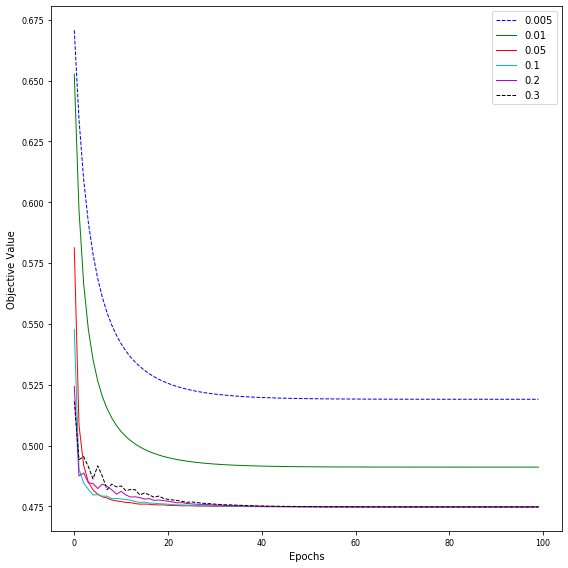

In [20]:
try6mbsdg (8,[.005,.01,.05,.1,.2,.3])

In [21]:
# MB-SGD with batch size b=8
lam = 1E-6 # do not change
b = 8 # do not change
stepsize = 0.05 # tuned

w, objvals_mbsgd8 = mb_sgd(x_train, y_train, lam, b, stepsize)


Objective value at epoch t=0 is 0.5783670982626331
Objective value at epoch t=1 is 0.5065007949126985
Objective value at epoch t=2 is 0.4916459530746037
Objective value at epoch t=3 is 0.4849629982597438
Objective value at epoch t=4 is 0.4813526960366393
Objective value at epoch t=5 is 0.4801837021547005
Objective value at epoch t=6 is 0.4792406171446224
Objective value at epoch t=7 is 0.47802593571616214
Objective value at epoch t=8 is 0.47763532318696
Objective value at epoch t=9 is 0.4772848078370009
Objective value at epoch t=10 is 0.47684724562603475
Objective value at epoch t=11 is 0.47663222374786285
Objective value at epoch t=12 is 0.4764790912790414
Objective value at epoch t=13 is 0.4762998816270517
Objective value at epoch t=14 is 0.4761444524727419
Objective value at epoch t=15 is 0.47595491873895146
Objective value at epoch t=16 is 0.47594938135039805
Objective value at epoch t=17 is 0.4757160992895792
Objective value at epoch t=18 is 0.4756729345829355
Objective value at 

Objective value at epoch t=0 is 0.6477887668771529
Objective value at epoch t=1 is 0.5832271261357591
Objective value at epoch t=2 is 0.5523693630155619
Objective value at epoch t=3 is 0.5344320108764723
Objective value at epoch t=4 is 0.5226154112946417
Objective value at epoch t=5 is 0.5148086602943045
Objective value at epoch t=6 is 0.5092810241890822
Objective value at epoch t=7 is 0.5050604205066287
Objective value at epoch t=8 is 0.5017764760504809
Objective value at epoch t=9 is 0.49909765408828166
Objective value at epoch t=10 is 0.49703195382747606
Objective value at epoch t=11 is 0.4954773793572502
Objective value at epoch t=12 is 0.49396988002050346
Objective value at epoch t=13 is 0.49283594160214816
Objective value at epoch t=14 is 0.4920200175441217
Objective value at epoch t=15 is 0.4910083734998583
Objective value at epoch t=16 is 0.49035518772237935
Objective value at epoch t=17 is 0.4897414578185398
Objective value at epoch t=18 is 0.4892693751733754
Objective value a

Objective value at epoch t=5 is 0.478616270189975
Objective value at epoch t=6 is 0.4782172570418283
Objective value at epoch t=7 is 0.47745788497129815
Objective value at epoch t=8 is 0.47697093890125525
Objective value at epoch t=9 is 0.4771507487705732
Objective value at epoch t=10 is 0.4766161028187283
Objective value at epoch t=11 is 0.47669494652689853
Objective value at epoch t=12 is 0.47608136126911865
Objective value at epoch t=13 is 0.47617169432527656
Objective value at epoch t=14 is 0.4760096039198395
Objective value at epoch t=15 is 0.47563954988460677
Objective value at epoch t=16 is 0.4757243897727501
Objective value at epoch t=17 is 0.47559824216602387
Objective value at epoch t=18 is 0.47559595778123376
Objective value at epoch t=19 is 0.47577703818738326
Objective value at epoch t=20 is 0.4755003559290876
Objective value at epoch t=21 is 0.4755967160407663
Objective value at epoch t=22 is 0.47528311085261316
Objective value at epoch t=23 is 0.47520302646693546
Objecti

Objective value at epoch t=63 is 0.4747710880315843
Objective value at epoch t=64 is 0.47477592046375927
Objective value at epoch t=65 is 0.4747710675556601
Objective value at epoch t=66 is 0.4747705342626837
Objective value at epoch t=67 is 0.47476784527789767
Objective value at epoch t=68 is 0.4747699826470523
Objective value at epoch t=69 is 0.47476938639104427
Objective value at epoch t=70 is 0.4747670828127476
Objective value at epoch t=71 is 0.47476747389361174
Objective value at epoch t=72 is 0.47476567897700955
Objective value at epoch t=73 is 0.47476663094298993
Objective value at epoch t=74 is 0.4747663870999451
Objective value at epoch t=75 is 0.4747656858321719
Objective value at epoch t=76 is 0.47476566832577777
Objective value at epoch t=77 is 0.4747654325231485
Objective value at epoch t=78 is 0.47476576101387213
Objective value at epoch t=79 is 0.4747656848730216
Objective value at epoch t=80 is 0.47476444679447843
Objective value at epoch t=81 is 0.47476476522549504
Ob

Objective value at epoch t=25 is 0.47563454644919395
Objective value at epoch t=26 is 0.47575807407735893
Objective value at epoch t=27 is 0.47545606773752624
Objective value at epoch t=28 is 0.4755397324421593
Objective value at epoch t=29 is 0.4756282967398634
Objective value at epoch t=30 is 0.47557114538199163
Objective value at epoch t=31 is 0.47529636360769106
Objective value at epoch t=32 is 0.4752898467456845
Objective value at epoch t=33 is 0.4752929540270614
Objective value at epoch t=34 is 0.47517876473268605
Objective value at epoch t=35 is 0.4751314625669326
Objective value at epoch t=36 is 0.47519626873062537
Objective value at epoch t=37 is 0.47502997559112414
Objective value at epoch t=38 is 0.4750824391556934
Objective value at epoch t=39 is 0.47507576105522115
Objective value at epoch t=40 is 0.4749842987281555
Objective value at epoch t=41 is 0.4749888642548659
Objective value at epoch t=42 is 0.47495768599738186
Objective value at epoch t=43 is 0.4749463460366362
Ob

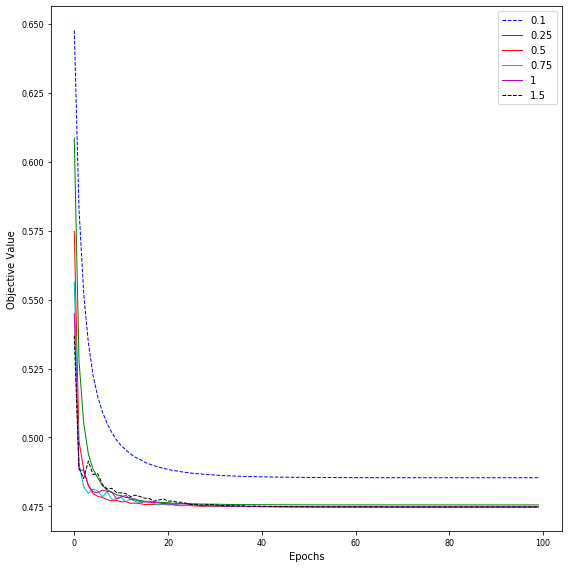

In [22]:
try6mbsdg (64,[.1,.25,.5,.75,1,1.5])

In [23]:
# MB-SGD with batch size b=64
lam = 1E-6 # do not change
b = 64 # do not change
stepsize = 0.5 # Tuned

w, objvals_mbsgd64 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch t=0 is 0.5745392156396758
Objective value at epoch t=1 is 0.49896272970080097
Objective value at epoch t=2 is 0.4868530571493731
Objective value at epoch t=3 is 0.48147799634889965
Objective value at epoch t=4 is 0.48078693828844987
Objective value at epoch t=5 is 0.4782792032798149
Objective value at epoch t=6 is 0.47802733208992026
Objective value at epoch t=7 is 0.47830832963234915
Objective value at epoch t=8 is 0.47767016806342355
Objective value at epoch t=9 is 0.47680669474521736
Objective value at epoch t=10 is 0.4769543136893537
Objective value at epoch t=11 is 0.4763571737492963
Objective value at epoch t=12 is 0.4765286109223078
Objective value at epoch t=13 is 0.4761010805871389
Objective value at epoch t=14 is 0.4759106621964018
Objective value at epoch t=15 is 0.476171652984452
Objective value at epoch t=16 is 0.4756361466574755
Objective value at epoch t=17 is 0.47573076941030357
Objective value at epoch t=18 is 0.4758109497076285
Objective value

# 7. Plot and compare GD, SGD, and MB-SGD

You are required to compare the following algorithms:

- Gradient descent (GD)

- SGD

- MB-SGD with b=8

- MB-SGD with b=64

Follow the code in Section 4 to plot ```objective function value``` against ```epochs```. There should be four curves in the plot; each curve corresponds to one algorithm.

Hint: Logistic regression with $\ell_2$-norm regularization is a strongly convex optimization problem. All the algorithms will converge to the same solution. **In the end, the ``objective function value`` of the 4 algorithms will be the same. If not the same, your implementation must be wrong. Do NOT submit wrong code and wrong result!**

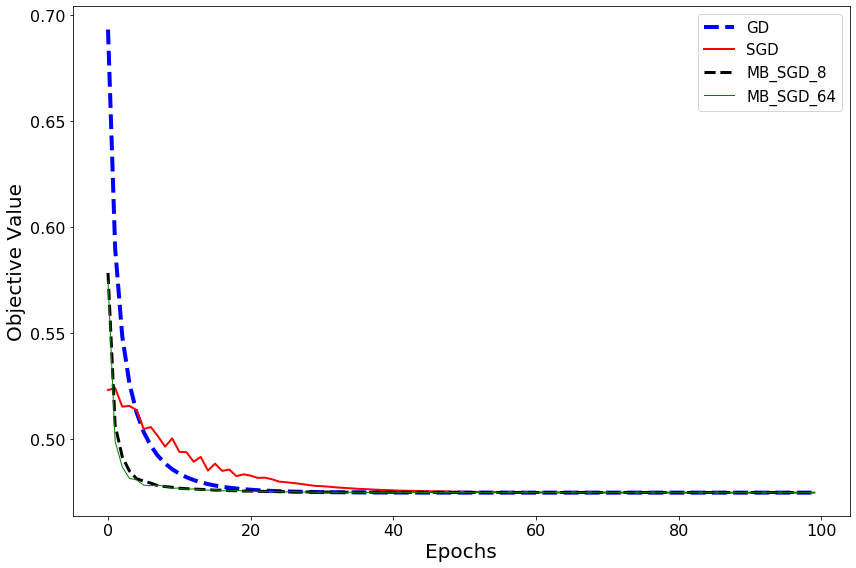

In [24]:
# plot the 4 curves:
fig = plt.figure(figsize=(12, 8))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))
epochs_MB8 = range(len(objvals_mbsgd8))
epochs_MB64 = range(len(objvals_mbsgd64))


line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
line2, = plt.plot(epochs_MB8, objvals_mbsgd8, '--k', LineWidth=3)
line3, = plt.plot(epochs_MB64, objvals_mbsgd64, '-g', LineWidth=1)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1,line2,line3], ['GD', 'SGD','MB_SGD_8','MB_SGD_64'], fontsize=15)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd_MB.pdf', format='pdf', dpi=1200)